<a href="https://colab.research.google.com/github/ramy-arab/cnn-skin-lesion-segmentation/blob/main/ph2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Clone Dataset Repository

In [1]:
!git clone https://github.com/ramy-arab/pfe-dataset.git

Cloning into 'pfe-dataset'...
remote: Enumerating objects: 1052, done.
remote: Total 1052 (delta 0), reused 0 (delta 0), pack-reused 1052 (from 1)
Receiving objects: 100% (1052/1052), 198.30 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (235/235), done.
Updating files: 100% (446/446), done.


#### Load and Preprocess Data

In [3]:
import os
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Set the path to the PH2 Dataset folder
dataset_path = '/content/pfe-dataset/PH2Dataset'

def load_data(dataset_path):
    images, masks = [], []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            image_path = os.path.join(folder_path, f'{folder}_Dermoscopic_Image', f'{folder}.bmp')
            mask_path = os.path.join(folder_path, f'{folder}_lesion', f'{folder}_lesion.bmp')
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if image is not None and mask is not None:
                image = cv2.resize(image, (256, 256)) / 255.0
                mask = cv2.resize(mask, (256, 256)) / 255.0
                masks.append(np.expand_dims(mask, axis=-1))
                images.append(image)
    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_data(dataset_path)

#### Split Dataset

In [4]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 147, Val: 29, Test: 20


###Define Evaluation Metrics

In [5]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def sensitivity(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    return (tp + 1e-7) / (tp + fn + 1e-7)

def specificity(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tn = K.sum((1 - y_true_f) * (1 - y_pred_f))
    fp = K.sum((1 - y_true_f) * y_pred_f)
    return (tn + 1e-7) / (tn + fp + 1e-7)

###Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide same seed to match augmentation of images and masks
seed = 42
image_generator = image_datagen.flow(X_train, seed=seed)
mask_generator = mask_datagen.flow(y_train, seed=seed)

# Combine generators
train_generator = zip(image_generator, mask_generator)


###Defining U-Net Model

In [8]:
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)

    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv4, up6])
    conv6 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge6)

    up7 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7])
    conv7 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge7)

    up8 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8])
    conv8 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge8)

    up9 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9])
    conv9 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(merge9)

    conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    model = tf.keras.models.Model(inputs, conv10)
    return model

model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient, jaccard_index, sensitivity, specificity])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 256)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 256)    │        524,544 │ conv2d_24[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 6,976,257 (26.61 MB)

 Trainable params: 6,976,257 (26.61 MB)

 Non-trainable params: 0 (0.00 B)

###Training

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Callbacks with the correct file extension
checkpoint = ModelCheckpoint('unet_ph2_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=50,
                    callbacks=[checkpoint, reduce_lr, early_stopping])


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.6830 - dice_coefficient: 0.3795 - jaccard_index: 0.2353 - loss: 0.6682 - sensitivity: 0.4817 - specificity: 0.5278 - val_accuracy: 0.6473 - val_dice_coefficient: 0.4071 - val_jaccard_index: 0.2555 - val_loss: 0.6424 - val_sensitivity: 0.4609 - val_specificity: 0.5653 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.6923 - dice_coefficient: 0.3665 - jaccard_index: 0.2248 - loss: 0.6286 - sensitivity: 0.4437 - specificity: 0.5804 - val_accuracy: 0.6473 - val_dice_coefficient: 0.3981 - val_jaccard_index: 0.2486 - val_loss: 0.6047 - val_sensitivity: 0.4168 - val_specificity: 0.6339 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.6934 - dice_coefficient: 0.3538 - jaccard_index: 0.2153 - loss: 0.5810 - sensitivity: 0.3796 - specificity: 0.6682 - val_accuracy: 0.6473 - val_dice_coefficient: 0.3735 - val_jaccard_index: 0.2296 - val_loss: 0.

###Evaluating the Model on Test Data

In [11]:
test_results = model.evaluate(X_test, y_test)
print("Test Results:")
for metric, value in zip(model.metrics_names, test_results):
    print(f"{metric}: {value:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9443 - dice_coefficient: 0.8815 - jaccard_index: 0.7881 - loss: 0.1423 - sensitivity: 0.8691 - specificity: 0.9484
Test Results:
loss: 0.1423
compile_metrics: 0.9443


In [12]:
# Model Graphical Interpretation

h= history.history
h.keys()

dict_keys(['accuracy', 'dice_coefficient', 'jaccard_index', 'loss', 'sensitivity', 'specificity', 'val_accuracy', 'val_dice_coefficient', 'val_jaccard_index', 'val_loss', 'val_sensitivity', 'val_specificity', 'learning_rate'])

###Visualizing Training Performance Metrics

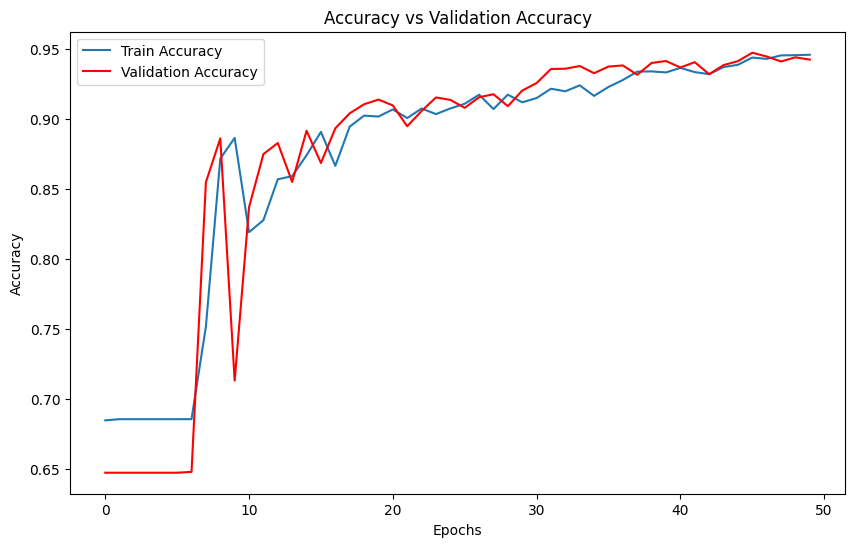

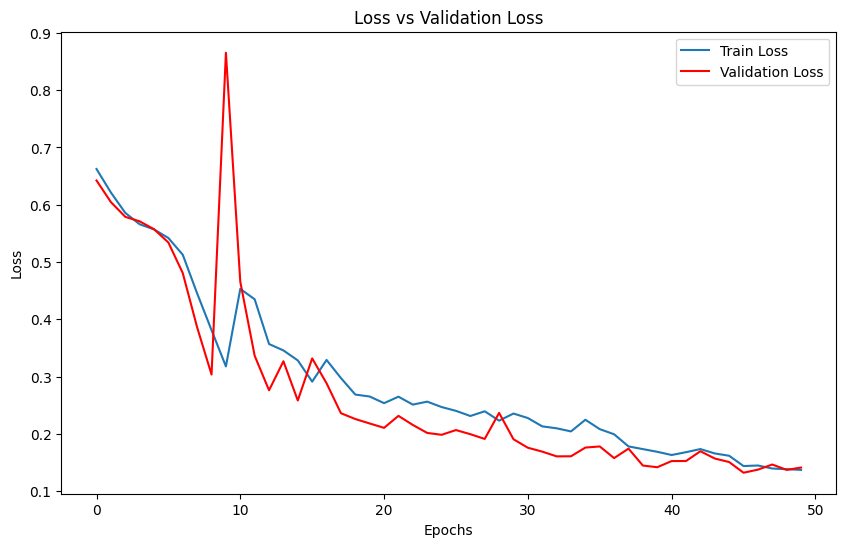

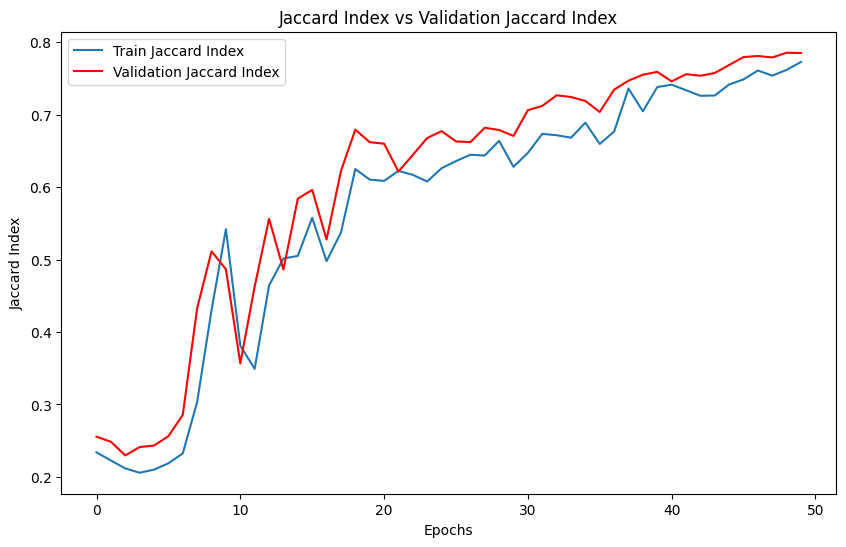

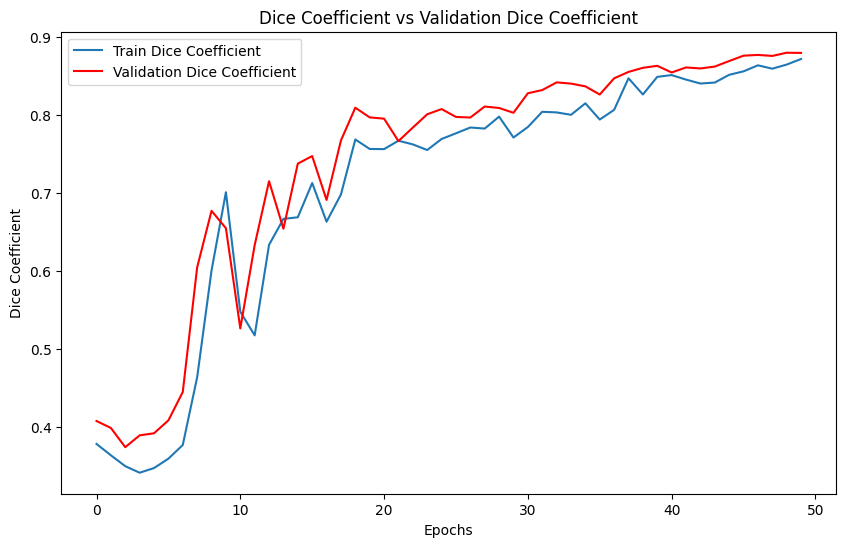

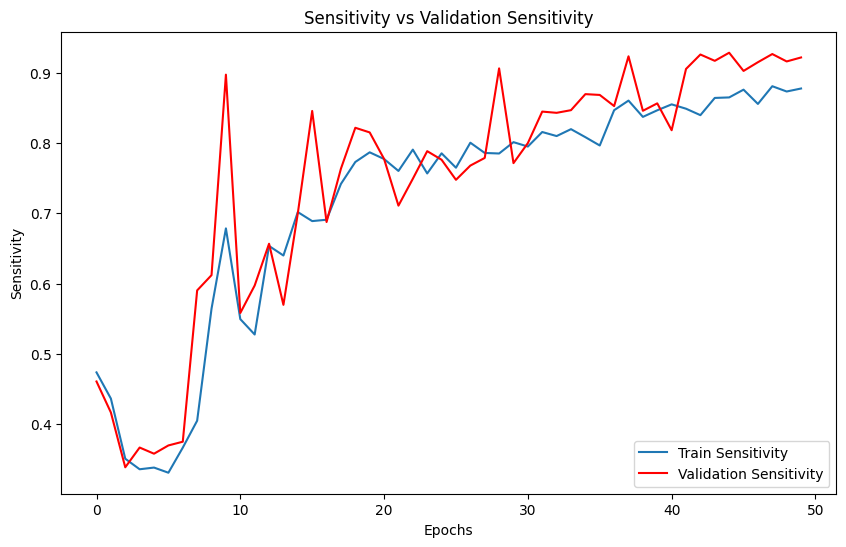

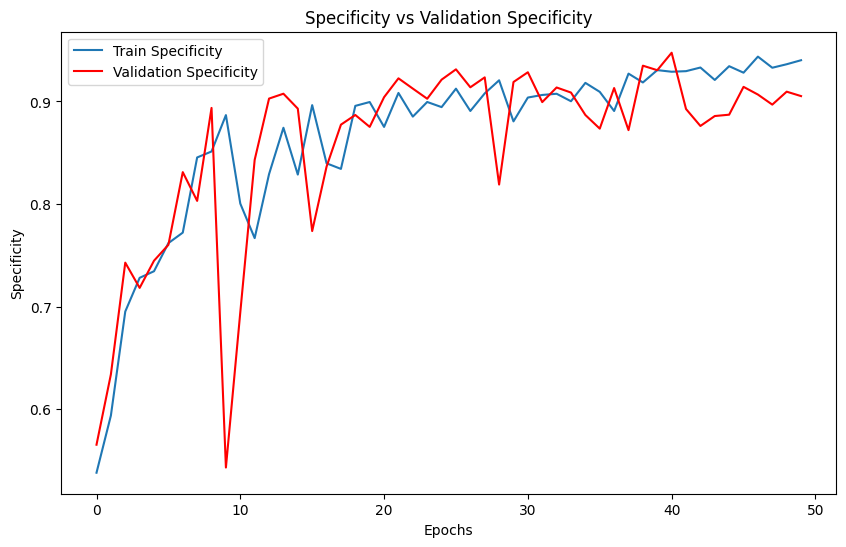

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(h['accuracy'], label='Train Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy', c="red")
plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(h['loss'], label='Train Loss')
plt.plot(h['val_loss'], label='Validation Loss', c="red")
plt.title("Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Jaccard Index
plt.figure(figsize=(10, 6))
plt.plot(h['jaccard_index'], label='Train Jaccard Index')
plt.plot(h['val_jaccard_index'], label='Validation Jaccard Index', c="red")
plt.title("Jaccard Index vs Validation Jaccard Index")
plt.xlabel("Epochs")
plt.ylabel("Jaccard Index")
plt.legend()
plt.show()

# Plot Dice Coefficient
plt.figure(figsize=(10, 6))
plt.plot(h['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(h['val_dice_coefficient'], label='Validation Dice Coefficient', c="red")
plt.title("Dice Coefficient vs Validation Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.show()

# Plot Sensitivity
plt.figure(figsize=(10, 6))
plt.plot(h['sensitivity'], label='Train Sensitivity')
plt.plot(h['val_sensitivity'], label='Validation Sensitivity', c="red")
plt.title("Sensitivity vs Validation Sensitivity")
plt.xlabel("Epochs")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

# Plot Specificity
plt.figure(figsize=(10, 6))
plt.plot(h['specificity'], label='Train Specificity')
plt.plot(h['val_specificity'], label='Validation Specificity', c="red")
plt.title("Specificity vs Validation Specificity")
plt.xlabel("Epochs")
plt.ylabel("Specificity")
plt.legend()
plt.show()


###Visualizing Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


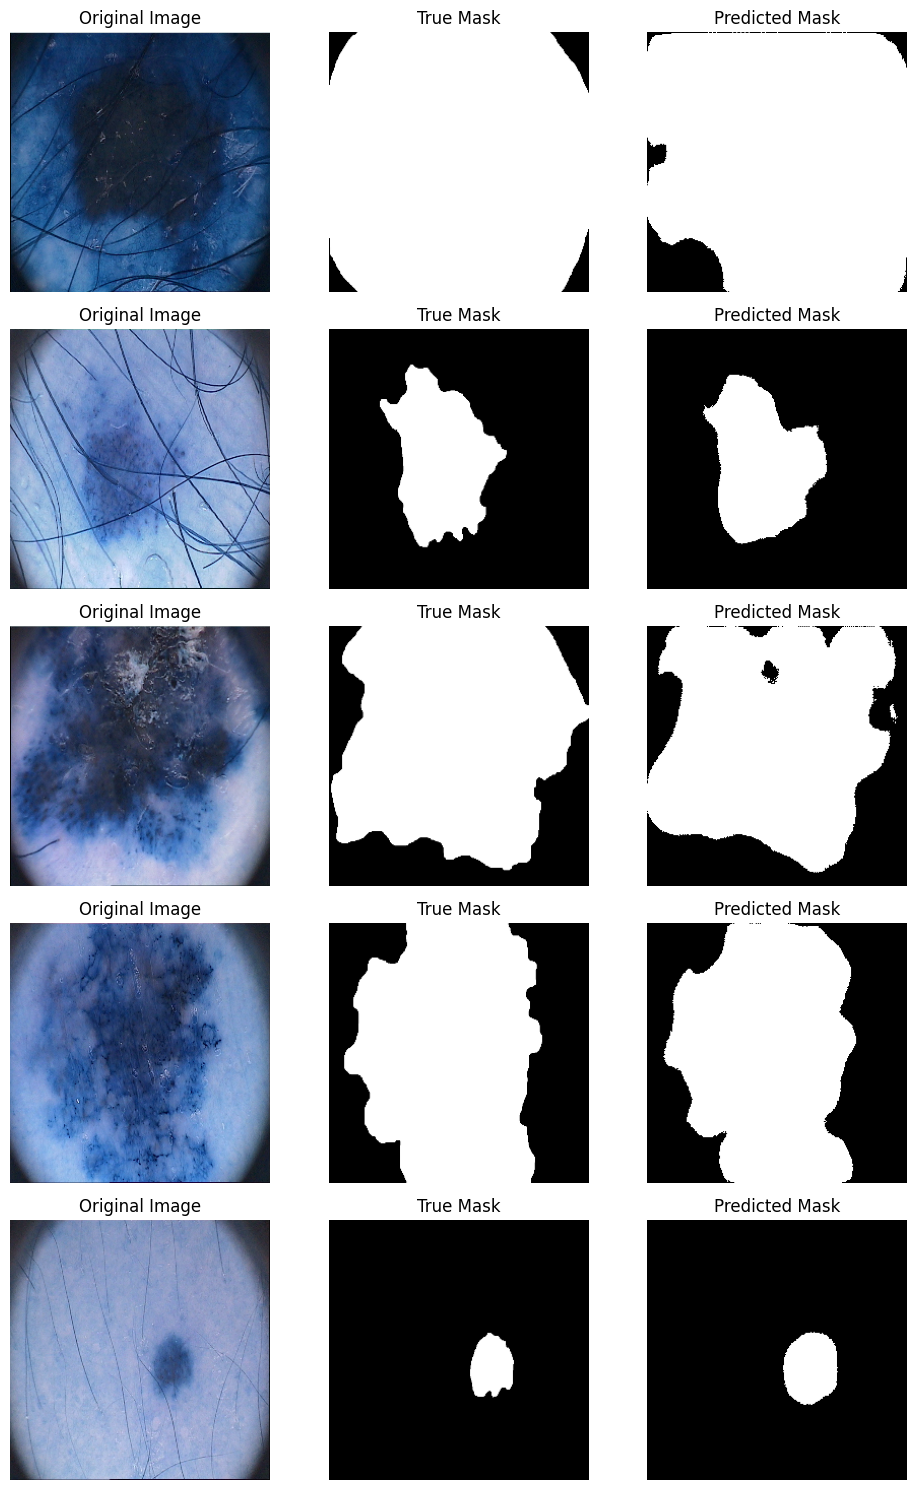

In [14]:

# Plot Predictions
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i in range(num_samples):
    idx = np.random.randint(0, len(X_val))
    image = X_val[idx]
    true_mask = y_val[idx]
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold for binary mask

    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(true_mask[:, :, 0], cmap="gray")
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(predicted_mask[:, :, 0], cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
